In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences

from src.data_processing.processors.SequenceProcessor import SequenceProcessor
from src.utilities.pandas_helpers import get_features

plt.rcParams['path.simplify_threshold'] = 1.0
plt.rcParams['agg.path.chunksize'] = 2000 


2023-07-27 16:27:45.017346: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Objectives to restructer data:
* one hot encode mice (done)
* encode cyclic time : time_sin and time_cos

In [3]:
# DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
DATA_PATH = "/Users/michaelschaid/interm_data_transfer/full_dataset.parquet.gzip" #local

In [4]:
data = pd.read_parquet(DATA_PATH)
# data = data[::1000].reset_index(drop=True) # subsample for speed
sensor_cols = [col for col in data.columns if "sensor_" in col]
da_data = data.query("sensor_DA==1").drop(sensor_cols, axis=1).reset_index(drop=True)
da_data

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,latency,...,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13
0,-25.000000,1,5,0,110,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-24.901531,1,5,0,110,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,-24.803064,1,5,0,110,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,-24.704596,1,5,0,110,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,-24.606127,1,5,0,110,0,0,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2935368,19.606127,1,4,11,98,1,0,1,0,5.5,...,0,1,0,0,0,0,0,0,0,0
2935369,19.704596,1,4,11,98,1,0,1,0,5.5,...,0,1,0,0,0,0,0,0,0,0
2935370,19.803064,1,4,11,98,1,0,1,0,5.5,...,0,1,0,0,0,0,0,0,0,0
2935371,19.901531,1,4,11,98,1,0,1,0,5.5,...,0,1,0,0,0,0,0,0,0,0


# Concept for data structure 
<span style="color:red">**batch size**</span> since we are training for trial_count, we consider each subject (mouse) a batch. 

<span style="color:red">**Sequence length**</span> This is the number of time steps, in this case we consider 1 time step, 1 sequence length. Since the trials are different lengths, we will need to pad the shorter sequences. We will use a value of 1000 filled with zeros, so our model will learn to ignore them. *we might be able to get away with a lambda layer* 

<span style="color:red">**Number of features**</span> everything else, including time (seconds)


# Preprocessing for LSTM input 


## Semgementation 
*  Spit data into seperate dataframes for each subject
*  Also need to restructure so signal for each event is seperated, and we will predict all 4 signals from the given data. Might have issues with missing data, but hopefully padding corrects that

## Drop Unnessary columns

* Since we are segmenting by subject, we can drop mouse_id columns
* we need to track this data externally, we can do so in pandas and save it
  
## Pad sequences 
* to control for varying length 
``` {python}
from tensorflow.keras.preprocessing.sequence import pad_sequence
```

## Reshape data for LSTM
``` LSTM(num_seq, sequence_length, num_features)```

* num_seq: number of subjects

* sequence_length: number of trials

* num_features: features minus trial_count and subject_identifies

In [37]:
# query for DA sensor and drop others
sensor_cols = [col for col in data.columns if "sensor_" in col]
da_data = data.query("sensor_DA==1").drop(sensor_cols, axis=1).reset_index(drop=True)

da_seq_proc = (
    SequenceProcessor(data = da_data) # load data into sp
    .encode_cyclic_time() # encode time as sin/cos
    .batch_by_subject(subject_prefix = 'mouse_id_') # batch by subject and store
    .pad_batches(value = -1000)
    .split_training_val_test_batches(target = 'signal') # split batches and store into attributes
)

In [21]:
da_data.sort_values(by = "trial_count")

,time,sex_M,day,trial,trial_count,learning_phase,event_cue,event_escape,event_avoid,latency,...,mouse_id_4,mouse_id_5,mouse_id_6,mouse_id_7,mouse_id_8,mouse_id_9,mouse_id_10,mouse_id_11,mouse_id_12,mouse_id_13
1300754,-23.719912,1,1,0,0,0,1,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1353540,-12.297593,0,1,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1353541,-12.199124,0,1,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1353542,-12.100657,0,1,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1353543,-12.002188,0,1,0,0,0,0,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963539,6.017506,1,7,28,202,2,1,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
963540,6.115974,1,7,28,202,2,1,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
963541,6.214442,1,7,28,202,2,1,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0
963543,6.411378,1,7,28,202,2,1,0,0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [15]:
def batches_to_np(batches):
    return np.stack([batch.to_numpy() for batch in batches])


x_train_arr = batches_to_np(da_seq_proc.train_batches_X)
y_train_arr = batches_to_np(da_seq_proc.train_batches_y)

x_val_arr = batches_to_np(da_seq_proc.val_batches_X)
y_val_arr = batches_to_np(da_seq_proc.val_batches_y)

x_test_arr = batches_to_np(da_seq_proc.test_batches_X)
y_test_arr = batches_to_np(da_seq_proc.test_batches_y)

In [27]:
x_train_arr.reshape(-1)

array([-25.,   0.,   5., ..., -10., -10., -10.], dtype=float32)

In [18]:
print( f'x_train shape is: {x_train_arr.shape}' )
print(f'y_train shape is: {y_train_arr.shape}')
print(f'x_val shape is: {x_val_arr.shape}')
print(f'y_val shape is: {y_val_arr.shape}')
print(f'x_test shape is: {x_test_arr.shape}')
print(f'y_test shape is: {y_test_arr.shape}')

x_train shape is: (9, 243993, 14)
y_train shape is: (9, 243993)
x_val shape is: (2, 243993, 14)
y_val shape is: (2, 243993)
x_test shape is: (3, 243993, 14)
y_test shape is: (3, 243993)


In [30]:
sec = 1.1E7

<Axes: xlabel='time'>

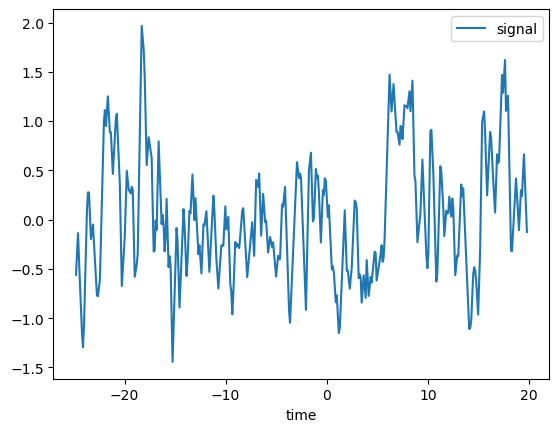

In [107]:
df = (
    da_seq_proc.train_batches_X[0]
    .assign(signal = da_seq_proc.train_batches_y[0])
    .sort_values(by = ['trial_count', 'time']).query('time>-99 & event_cue==1 & trial_count==20')
    .rolling(window =5 , center = True).mean().dropna()
    )
df.plot(x = 'time', y = 'signal')



count    458.000000
mean      -2.500000
std       13.033011
min      -25.000000
25%      -13.750000
50%       -2.500000
75%        8.750000
max       20.000000
Name: time, dtype: float64

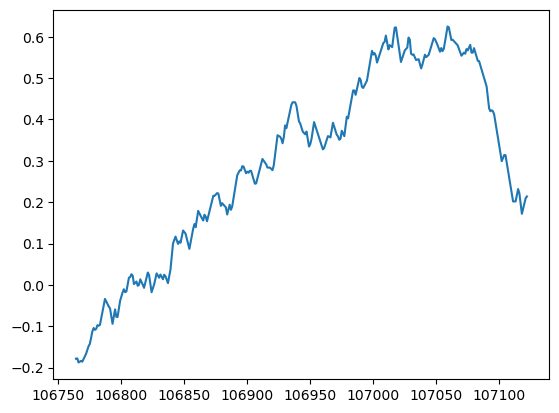

In [78]:
plt.plot(df.signal)